In [1]:
import os
import pandas as pd
from kaggle.competitions import nflrush
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
import pickle
import tqdm
import category_encoders
import seaborn as sns
import pandas_profiling as pdp
pd.set_option("display.max_columns",1000)

In [2]:
# 参考 https://upura.hatenablog.com/entry/2019/01/12/193000
# https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment data augmentationを他クラス用に改造する
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style("whitegrid")
    plt.figure()
    fig, ax = plt.subplots(4,4, figsize=(14,14))
    
    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker= "+")
        plt.xlabel(feature, fontsize=9)
    plt.show()
    
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,5,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(5,5,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=15)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()
    
def plot_feature(df1, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,5,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(5,5,i)
        if "int" in str(df1[feature].dtype): # int type variable
            sns.distplot(df1[feature], kde=False, hist=True)
        else: # float type variable
            sns.distplot(df1[feature], hist=False)
        #sns.distplot(df1[feature], hist=False)#,label=feature)
        plt.xlabel(feature, fontsize=10)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

def violinplot_feature_by_class(df1, features, target):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,5,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(5,5,i)
        sns.violinplot(x=target, y=feature, data = df1)
        plt.xlabel(feature, fontsize=10)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show()
    
def scatterplot_feature_by_class(df1, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,5,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(5,5,i)
        plt.scatter(df1[feature], df1["Root Cause Function Block"])
        plt.xlabel(feature, fontsize=10)
        plt.ylabel("Root Cause Function Block", fontsize=10)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=10)
        plt.yticks(np.arange(21))
    plt.show()
    
def scatterplot_highcorr_feature(df1, features, corr_df):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,5,figsize=(18,22))
    for feature in features:
        corr_feats = list(corr_df[corr_df["level_0"] == feature][:5]["level_1"])
        corr_value = list(corr_df[corr_df["level_0"] == feature][:5]["value"])

        for idx in range(len(corr_feats)):
            i += 1
            plt.subplot(5,5,i)
            plt.scatter(df1[corr_feats[idx]], df1[feature])
            plt.xlabel(corr_feats[idx], fontsize=10)
            plt.ylabel(feature, fontsize=10)
            locs, labels = plt.xticks()
            plt.tick_params(axis='x', which='major', labelsize=10, pad=-6)
            plt.tick_params(axis='y', which='major', labelsize=10)
            plt.title(str(round(corr_value[idx],5)))
    plt.show()
    
def plot_diff_feature(df1, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    #fig, ax = plt.subplots(5,5,figsize=(18,22))
    plt.figure(figsize=(15,20))
    for j in range(21):
        i += 1
        plt.subplot(5,5,i)
        tmp_df = df1[df1[target_feature]==j]

        for feature in features:
            sns.distplot(tmp_df[feature], hist=False, label=str(feature))
        plt.xlabel("class_"+str(j), fontsize=10)
        locs, labels = plt.xticks()
        plt.legend(loc="upper right")
        plt.tick_params(axis='x', which='major', labelsize=15, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=15)
    plt.show()

In [3]:
env = nflrush.make_env()

In [4]:
train_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)

In [5]:
train_df.head(3)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

# Data cleaning

In [7]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1

# data cleaning 
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train_df['PossessionTeam'].unique():
    map_abbr[abb] = abb
train_df['PossessionTeam'] = train_df['PossessionTeam'].map(map_abbr)
train_df['HomeTeamAbbr'] = train_df['HomeTeamAbbr'].map(map_abbr)
train_df['VisitorTeamAbbr'] = train_df['VisitorTeamAbbr'].map(map_abbr)

# offense formation
train_df["OffenseFormation"] = train_df["OffenseFormation"].fillna("Unknown") 

# Stadium
train_df["Stadium"] = train_df["Stadium"].map(lambda x: "Broncos Stadium at Mile High" if x=="Broncos Stadium At Mile High" 
                                             else ("CenturyLink Field" if x == "CenturyField" or x == x=="CenturyLink"
                                             else ("Everbank Field" if x == "EverBank Field"
                                             else ("FirstEnergy Stadium" if x =="First Energy Stadium" or x=="FirstEnergy" or x == "FirstEnergyStadium"
                                             else ("Lambeau Field" if x == "Lambeau field"
                                             else ("Los Angeles Memorial Coliseum" if x == "Los Angeles Memorial Coliesum"
                                             else ("M&T Bank Stadium" if x == "M & T Bank Stadium" or x == "M&T Stadium"
                                             else ("Mercedes-Benz Superdome" if x == "Mercedes-Benz Dome"
                                             else ("MetLife Stadium" if x == "MetLife" or x == "Metlife Stadium"
                                             else ("NRG Stadium" if x == "NRG"
                                             else ("Oakland-Alameda County Coliseum" if x == "Oakland Alameda-County Coliseum"
                                             else ("Paul Brown Stadium" if x == "Paul Brown Stdium"
                                             else ("Twickenham Stadium" if x == "Twickenham" else x)))))))))))))

# Location
train_df["Location"] = train_df["Location"].map(lambda x: "Arlington, TX" if x == "Arlington, Texas"
                        else ("Baltimore, MD" if x == "Baltimore, Maryland" or x == "Baltimore, Md."
else ("Charlotte, NC" if x == "Charlotte, North Carolina"
                        else ("Chicago, IL" if x == "Chicago. IL"
                        else ("Cincinnati, OH" if x == "Cincinnati, Ohio"
                        else ("Cleveland, OH" if x == "Cleveland" or x == "Cleveland Ohio" or x == "Cleveland, Ohio" or x == "Cleveland,Ohio"
                        else ("Detroit, MI" if x == "Detroit"
                        else ("East Rutherford, NJ" if x == "E. Rutherford, NJ" or x == "East Rutherford, N.J."
                        else ("Foxborough, MA" if x == "Foxborough, Ma"
                        else ("Houston, TX" if x == "Houston, Texas"
                        else ("Jacksonville, FL" if x == "Jacksonville Florida" or x == "Jacksonville, Fl" or x == "Jacksonville, Florida"
                        else ("London" if x == "London, England"
                        else ("Los Angeles, CA" if x == "Los Angeles, Calif."
                        else ("Miami Gardens, FLA" if x == "Miami Gardens, Fla."
                        else ("New Orleans, LA" if x == "New Orleans" or x == "New Orleans, La."
                        else ("Orchard Park, NY" if x == "Orchard Park NY"
                        else ("Philadelphia, PA" if x == "Philadelphia, Pa."
                        else ("Pittsburgh, PA" if x == "Pittsburgh"
                        else ("Seattle, WA" if x == "Seattle" else x)))))))))))))))))))

# Turf
train_df["Turf"] = train_df["Turf"].map(lambda x: "Artificial" if x == "Artifical"
                                       else ("Field Turf" if x == "FieldTurf" or x == "Field turf"
                                       else ("FieldTurf 360" if x == "FieldTurf360"
                                       else ("Natural Grass" if x == "natural grass" or x == "Naturall Grass" or x == "Natural grass" or x == "Natural"
                                       else ("Grass" if x == "grass"
                                       else ("UBU Speed Series-S5-M" if x == "UBU Sports Speed S5-M" else x))))))

# Player Height
train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

# stadium type
outdoor =['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
         'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']
indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed',
                   'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed']
indoor_open = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
dome_closed = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
dome_open = ['Domed, Open', 'Domed, open']

train_df['StadiumType'] = train_df['StadiumType'].apply(lambda x: "outdoor" if x in outdoor 
                                                         else ("indoor closed" if x in indoor_closed
                                                        else ("indoor open" if x in indoor_open
                                                        else ("dome_closed" if x in dome_closed
                                                        else ("dome_open" if x in dome_open else "unknown")))))

# Game weather
rain = ['Rainy', 'Rain Chance 40%', 'Showers',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']
overcast = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
              'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
              'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
              'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
              'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
              'Partly Cloudy', 'Cloudy']
clear = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
           'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
           'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
           'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
           'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
           'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']
snow = ['Heavy lake effect snow', 'Snow']
none = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']

train_df['GameWeather'] = train_df['GameWeather'].apply(lambda x: "rain" if x in rain 
                                                         else ("overcast" if x in overcast
                                                        else ("clear" if x in clear
                                                        else ("snow" if x in snow
                                                        else ("indoor" if x in none else "unknown")))))

# wind speed
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(str_to_float)

# wind direction
train_df['WindDirection'] = train_df['WindDirection'].apply(lambda x: "north" if x == "N" or x == "FROM S"
                                                   else ("south" if x == 'S' or x== 'FROM N'
                                                   else ("west" if x == 'W' or x == 'FROM E'
                                                   else ("east" if x == 'E' or x == 'FROM W'
                                                   else ("north east" if x == 'FROM SW' or x == 'FROM SSW' or x == 'FROM WSW'
                                                   else ("north west" if x == 'FROM SE' or x == 'FROM SSE' or x == 'FROM ESE'
                                                   else ("south east" if x == 'FROM NW' or x == 'FROM NNW' or x == 'FROM WNW'
                                                   else ("south west" if x == 'FROM NE' or x == 'FROM NNE' or x == 'FROM ENE'
                                                   else ("north west" if x == 'NW' or x == 'NORTHWEST'
                                                   else ("north east" if x == 'NE' or x == 'NORTH EAST'
                                                   else ("south west" if x == 'SW' or x == 'SOUTHWEST'
                                                   else ("south east" if x == 'SE' or x == 'SOUTHEAST' else "unknown"))))))))))))

# create new features
train_df['DefendersInTheBox_vs_Distance'] = train_df['DefendersInTheBox'] / train_df['Distance']
train_df['IsRusher'] = train_df['NflId'] == train_df['NflIdRusher']
train_df["Margin"] = (train_df["HomeScoreBeforePlay"] - train_df["VisitorScoreBeforePlay"]) + 2 * (1 - (train_df["PossessionTeam"] == train_df["HomeTeamAbbr"]).astype(int)) * (train_df["VisitorScoreBeforePlay"] - train_df["HomeScoreBeforePlay"])

# analysis

In [8]:
train_df.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,Week,Temperature,Humidity,WindSpeed,DefendersInTheBox_vs_Distance,Margin
count,5.097620e+05,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509744.000000,509748.000000,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,5.097620e+05,509696.000000,509762.000000,509762.000000,509762.000000,509762.000000,461230.000000,503602.000000,442332.000000,509696.000000,509762.000000
mean,2.017594e+09,2.017594e+13,60.040304,26.783535,2.591912,1.683176,0.279406,180.247779,179.933859,2.344703e+06,54.187982,2017.486427,28.368737,2.504639,1.520651,8.329248,11.148073,9.501057,2.419204e+06,6.943025,4.212334,74.392777,253.554388,9.096370,60.436442,55.646062,7.388342,1.519602,0.847827
std,4.997098e+05,4.997098e+09,25.435261,7.238206,1.383601,0.976412,0.145482,104.298330,106.319488,6.418871e+05,28.379359,0.499816,13.010918,1.144105,0.674987,3.795208,10.277098,9.366413,5.357783e+05,0.991130,6.436167,2.602712,48.367386,5.000984,17.570291,25.430976,4.446068,2.021514,10.767393
min,2.017091e+09,2.017091e+13,0.660000,1.850000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+02,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.340000e+02,1.000000,-14.000000,66.000000,153.000000,1.000000,9.000000,0.000000,-1.000000,0.035714,-44.000000
25%,2.017111e+09,2.017111e+13,39.090000,22.730000,1.500000,0.940000,0.170000,90.630000,89.830000,2.532865e+06,26.000000,2017.000000,20.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.540011e+06,6.000000,1.000000,72.000000,210.000000,5.000000,48.000000,43.000000,4.000000,0.600000,-5.000000
50%,2.017123e+09,2.017123e+13,60.290000,26.790000,2.470000,1.540000,0.270000,179.700000,180.090000,2.543765e+06,56.000000,2017.000000,29.000000,3.000000,1.000000,10.000000,9.000000,7.000000,2.552582e+06,7.000000,3.000000,75.000000,245.000000,9.000000,62.000000,59.000000,7.000000,0.700000,0.000000
75%,2.018110e+09,2.018110e+13,80.970000,30.860000,3.560000,2.290000,0.390000,270.400000,270.190000,2.555343e+06,78.000000,2018.000000,39.000000,4.000000,2.000000,10.000000,17.000000,14.000000,2.557976e+06,8.000000,6.000000,76.000000,305.000000,14.000000,73.000000,71.000000,10.000000,1.166667,7.000000
max,2.018123e+09,2.018123e+13,116.840000,56.450000,9.410000,14.710000,1.390000,360.000000,360.000000,2.561671e+06,99.000000,2018.000000,50.000000,5.000000,4.000000,40.000000,57.000000,51.000000,2.561468e+06,11.000000,99.000000,81.000000,380.000000,17.000000,97.000000,100.000000,24.000000,11.000000,44.000000


In [9]:
train_df.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection',
       'DefendersInTheBox_vs_Distance', 'IsRusher', 'Margin'],
      dtype='object')

## composition

In [10]:
# standard deviation
std_zero_feature = []
for i in [i for i in train_df.columns if train_df[i].dtype != "object"]:
    if train_df[i].std() == 0:
        std_zero_feature.append(i)
print("std zero features: {}" .format(len(std_zero_feature))) 

std zero features: 0


In [11]:
train_df.isnull().sum()

GameId                               0
PlayId                               0
Team                                 0
X                                    0
Y                                    0
S                                    0
A                                    0
Dis                                  0
Orientation                         18
Dir                                 14
NflId                                0
DisplayName                          0
JerseyNumber                         0
Season                               0
YardLine                             0
Quarter                              0
GameClock                            0
PossessionTeam                       0
Down                                 0
Distance                             0
FieldPosition                     6424
HomeScoreBeforePlay                  0
VisitorScoreBeforePlay               0
NflIdRusher                          0
OffenseFormation                     0
OffensePersonnel         

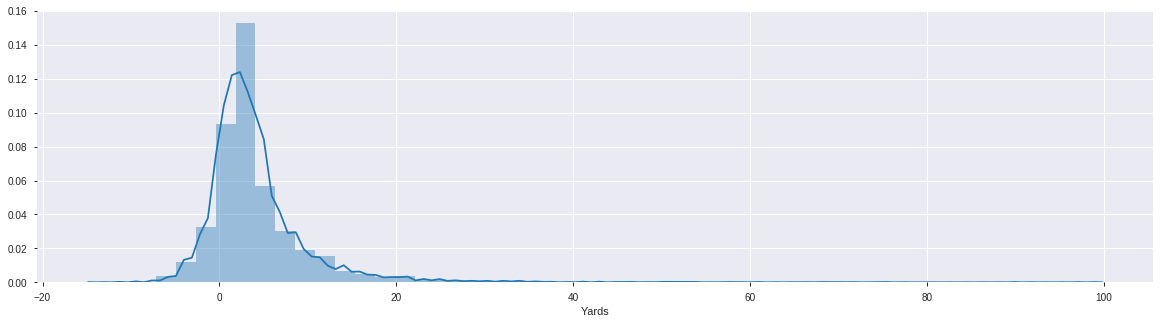

In [12]:
# yards
plt.figure(figsize=(20,5))
sns.distplot(train_df["Yards"])

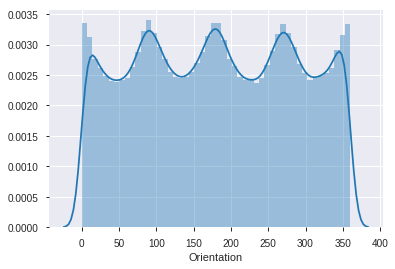

In [13]:
# orientation
tmp_df = train_df["Orientation"].dropna()
sns.distplot(tmp_df)

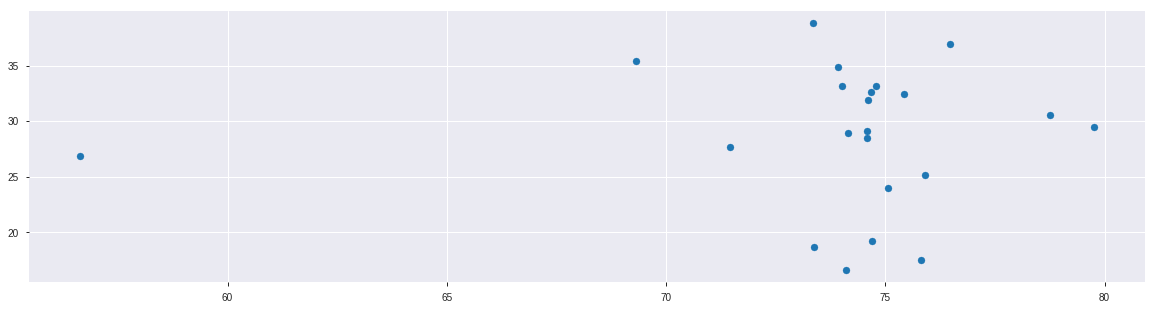

In [14]:
# X, Y
plt.figure(figsize=(20,5))
#train_df.plot.scatter(x='X', y='Y', c='PossessionTeam')
plt.scatter(train_df.iloc[0:22]["X"], train_df.iloc[0:22]["Y"])

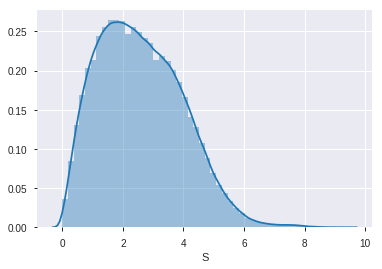

In [15]:
# S
sns.distplot(train_df[train_df.columns[5]])

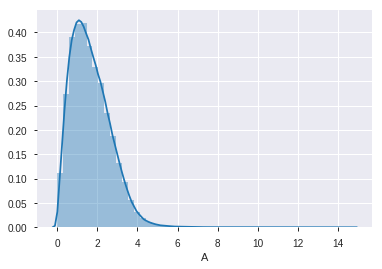

In [16]:
# A
sns.distplot(train_df[train_df.columns[6]])

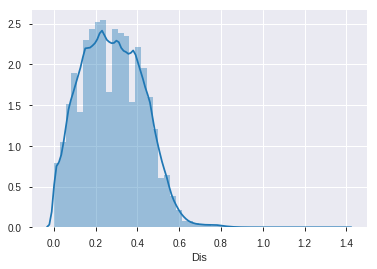

In [17]:
# Dis
sns.distplot(train_df[train_df.columns[7]])

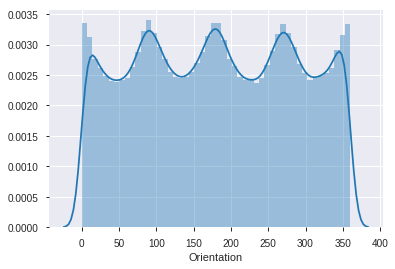

In [18]:
# Orientation
tmp_df = train_df[train_df.columns[8]].dropna()
sns.distplot(tmp_df)

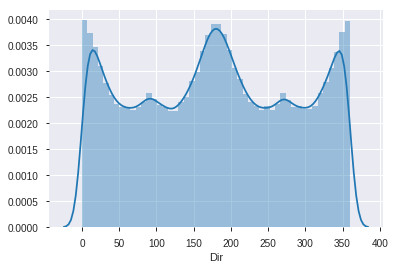

In [19]:
# Dir
tmp_df = train_df[train_df.columns[9]].dropna()
sns.distplot(tmp_df)

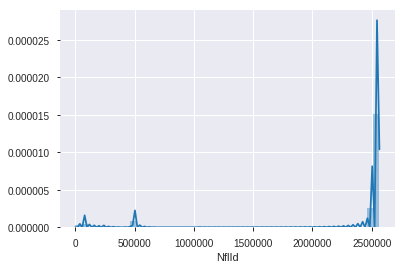

In [20]:
# nflid →特に使えないと思う
tmp_df = train_df[train_df.columns[10]].dropna()
sns.distplot(tmp_df)
# 次の変数は名前なので対象外

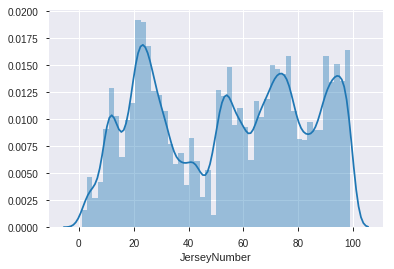

In [21]:
# Jerseynumber
tmp_df = train_df[train_df.columns[12]].dropna()
sns.distplot(tmp_df)

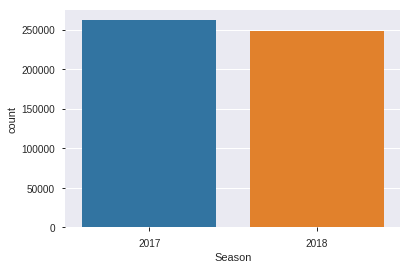

In [22]:
# season
tmp_df = train_df[train_df.columns[13]].dropna()
sns.countplot(tmp_df)

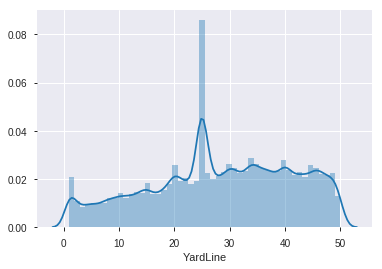

In [23]:
# yardline
tmp_df = train_df[train_df.columns[14]].dropna()
sns.distplot(tmp_df)

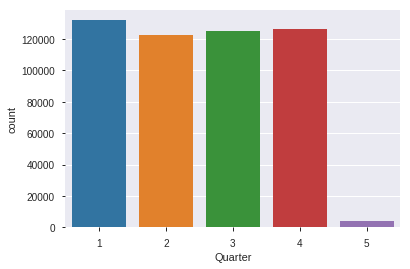

In [24]:
# quarter
tmp_df = train_df[train_df.columns[15]].dropna()
sns.countplot(tmp_df)

In [25]:
# Possession team: ボールを持っているチームの名称
train_df[train_df.columns[17]].value_counts()

NE     18700
LA     17952
BLT    17864
NO     17490
JAX    17490
SEA    17094
DAL    16918
HST    16764
MIN    16742
LAC    16698
DEN    16654
TEN    16544
PHI    16478
CHI    16368
BUF    16214
SF     16192
IND    16060
NYG    15642
DET    15554
NYJ    15532
ATL    15488
OAK    15422
PIT    15312
WAS    15092
ARZ    15092
KC     14300
CIN    14278
TB     14212
MIA    14168
CAR    14146
CLV    14102
GB     13200
Name: PossessionTeam, dtype: int64

In [26]:
# Down
train_df[train_df.columns[18]].value_counts()

1    292666
2    172986
3     39908
4      4202
Name: Down, dtype: int64

In [27]:
# Stadium
train_df["Stadium"].value_counts()

MetLife Stadium                        33572
Levis Stadium                          17402
Gillette Stadium                       17248
New Era Field                          17204
M&T Bank Stadium                       17094
CenturyLink Field                      16962
Paul Brown Stadium                     16588
Lucas Oil Stadium                      16544
Mercedes-Benz Superdome                16412
U.S. Bank Stadium                      16170
AT&T Stadium                           15950
NRG Stadium                            15884
Nissan Stadium                         15862
FedExField                             15356
Soldier Field                          15334
Arrowhead Stadium                      15334
Lambeau Field                          15312
Ford Field                             15246
Heinz Field                            14850
FirstEnergy Stadium                    14828
Raymond James Stadium                  14696
Los Angeles Memorial Coliseum          14674
StubHub Ce

In [28]:
# Stadium
train_df["Location"].value_counts()

East Rutherford, NJ    33572
Santa Clara, CA        17402
Foxborough, MA         17248
Orchard Park, NY       17204
Baltimore, MD          17094
Seattle, WA            16962
Cincinnati, OH         16588
Indianapolis, Ind.     16544
Denver, CO             16478
Glendale, AZ           16434
Minneapolis, MN        16170
Arlington, TX          15950
Houston, TX            15884
Nashville, TN          15862
New Orleans, LA        15554
Landover, MD           15356
Chicago, IL            15334
Green Bay, WI          15312
Detroit, MI            15246
Atlanta, GA            15246
Pittsburgh, PA         14850
Cleveland, OH          14828
Tampa, FL              14696
Los Angeles, CA        14674
Carson, CA             14630
Oakland, CA            14564
Miami Gardens, FLA     14564
Philadelphia, PA       14476
Kansas City, MO        14190
Jacksonville, FL       14124
Charlotte, NC          14036
London                  6644
Kansas City,  MO        1144
Mexico City              902
Name: Location

In [29]:
# WindDirection
train_df["WindDirection"].value_counts()

unknown       321068
north east     30250
north west     27236
south west     25828
south east     25784
north          23188
west           22198
south          21384
east           12826
Name: WindDirection, dtype: int64

In [30]:
# WindSpeed
train_df["WindSpeed"].value_counts()

 5.0     53284
 6.0     42614
 7.0     40678
 4.0     35486
 10.0    31592
 9.0     31328
 8.0     29370
 3.0     26862
 12.0    24552
 2.0     24112
 11.0    17116
 15.0    15026
 0.0     13772
 1.0     12078
 13.0    10208
 16.0     9878
 14.0     6820
 17.0     4928
-1.0      4202
 18.0     1980
 20.0     1848
 23.0     1166
 24.0      968
 18.5      968
 22.0      836
 19.0      660
Name: WindSpeed, dtype: int64

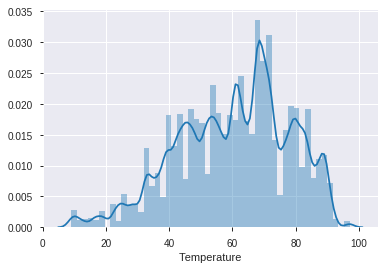

In [31]:
# temperature
tmp_df = train_df["Temperature"].dropna()
sns.distplot(tmp_df)

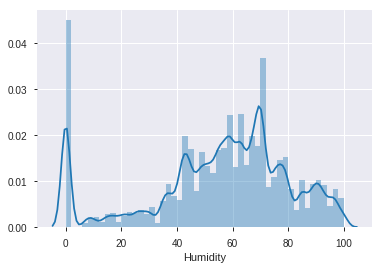

In [32]:
# humidity
tmp_df = train_df["Humidity"].dropna()
sns.distplot(tmp_df)